# Goal: Preprocessing, EDA, Models (Linear SVM, NB) implementation

#### Input Data: BBC News text data

Steps:
1. Combine all raw files into one dataframe
2. Preprocess text data
3. EDA
4. Model development and evaluation

In [1]:
## If following packages are not present do install by uncommenting following:
#!pip install nltk --quiet
#!pip install boto --quiet
#!pip install gensim --quiet

In [2]:
import os
import nltk
import gensim
import operator
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from itertools import combinations
#import seaborn as sns 
import matplotlib.pyplot as plt

#### Note:

#### the original raw data we want to use needed to be combined before we can use it.

We have following 5 directories in input data:
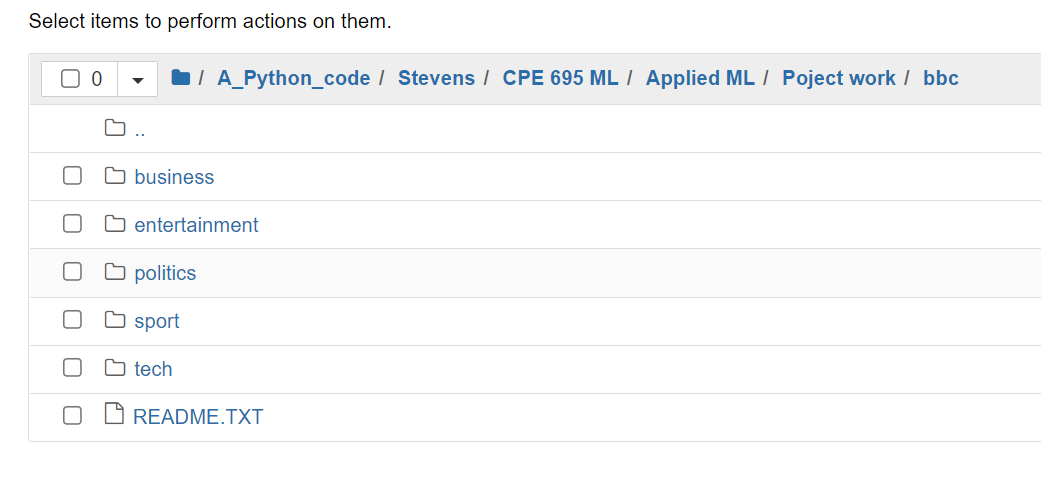

- Each folder contains the multiple text files ( individual news)
- For each folder combine those and label them accordingly
- finally combine all of them into one file

In [3]:
# NOTE: Put code file and data directory (containing data of all the news type) in the same directory

In [4]:
import glob 

In [5]:
#glob.glob(".\\bbc\\business\\*")

def get_data(strInputDataDirPath=".\\bbc\\"):
    
    pdInputData=pd.DataFrame()

    for strDirectoryName in ["business", "entertainment", "politics", "sport", "tech"]:

        print("Fetching data from directory: ", strDirectoryName)

        for strFileName in glob.glob(f"{strInputDataDirPath}{strDirectoryName}\\*"):

            with open(strFileName) as f:
                # append one row (one file) at a time to the dataframe
                strNews=f.read() 
                pdTemp =pd.DataFrame()
                
                pdTemp =pd.DataFrame({'NewsText': [strNews], 'NewsType': [strDirectoryName]})
                pdInputData = pdInputData.append(pdTemp, ignore_index=True)
                
                
    return pdInputData

%time pdInputData=get_data(strInputDataDirPath=".\\bbc\\")

Fetching data from directory:  business
Fetching data from directory:  entertainment
Fetching data from directory:  politics
Fetching data from directory:  sport
Fetching data from directory:  tech
Wall time: 19.5 s


In [6]:
pdInputData.describe()

,NewsText,NewsType
count,2225,2225
unique,2127,5
top,Blair dismisses quit claim report\n\nTony Blai...,sport
freq,2,511


In [7]:
pdInputData.to_csv("InputForVarnika.csv", index=False)

In [8]:
print("Null values: \n\n",pdInputData.isnull().sum())

Null values: 

 NewsText    0
NewsType    0
dtype: int64


In [9]:
print("Dropping duplicates: ", len(pdInputData)-len(pdInputData['NewsText'].drop_duplicates()) )
print("Before dropping duplicates number of rows: ", len(pdInputData))
pdInputData=pdInputData[['NewsText', 'NewsType']].drop_duplicates().reset_index()[['NewsText', 'NewsType']]
print("After dropping duplicates number of rows: ", len(pdInputData))

Dropping duplicates:  98
Before dropping duplicates number of rows:  2225
After dropping duplicates number of rows:  2127


<AxesSubplot:title={'center':'Count of news type in input'}, xlabel='NewsType'>

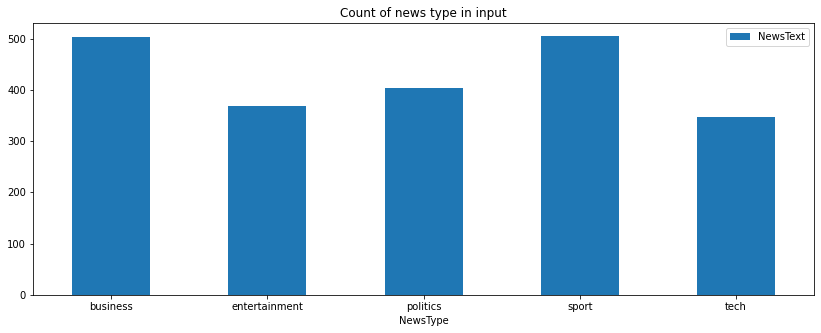

In [10]:
pdInputData.groupby("NewsType").count().plot(kind='bar', figsize=(14, 5), title="Count of news type in input", rot=360)

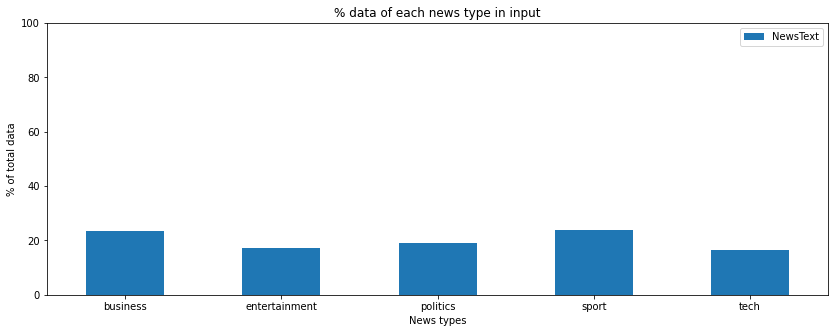

In [11]:
(100*pdInputData.groupby("NewsType").count()/len(pdInputData))\
      .plot(kind='bar', figsize=(14, 5), title="% data of each news type in input", rot=360)
plt.ylim([0, 100])
plt.ylabel("% of total data")
plt.xlabel("News types")
plt.show()

#OBSERVATION:
1. % wise distriution of data is more or less same acoss different classes

In [12]:
pdInputData.head()

,NewsText,NewsType
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [13]:
pdInputData['NewsTypeId'] = pdInputData['NewsType'].factorize()[0]

#View first 10 entries of category_id, as a sanity check
pdInputData['NewsTypeId'][0:10]
pdInputData.head(20)

,NewsText,NewsType,NewsTypeId
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,0
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,0
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,0
3,High fuel prices hit BA's profits\n\nBritish A...,business,0
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,0
5,Japan narrowly escapes recession\n\nJapan's ec...,business,0
6,Jobs growth still slow in the US\n\nThe US cre...,business,0
7,"India calls for fair trade rules\n\nIndia, whi...",business,0
8,Ethiopia's crop production up 24%\n\nEthiopia ...,business,0
9,Court rejects $280bn tobacco case\n\nA US gove...,business,0


In [14]:
pdCategory_id_df = pdInputData[['NewsType', 'NewsTypeId']].drop_duplicates().sort_values('NewsTypeId')
pdCategory_id_df

,NewsType,NewsTypeId
0,business,0
503,entertainment,1
872,politics,2
1275,sport,3
1780,tech,4


In [15]:
pdCategory_to_id = dict(pdCategory_id_df.values)
pdId_to_category = dict(pdCategory_id_df[['NewsTypeId', 'NewsType']].values)
pdId_to_category

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}

In [16]:
pdCategory_to_id

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2),\
                        stop_words='english')

features = tfidf.fit_transform(pdInputData.NewsType).toarray() # Remaps the words in the 1490 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = pdInputData.NewsTypeId                           # represents the category of each of the 1490 articles

In [18]:
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it

def get_chi_analysis(Category, category_id):
    
    # Do chi2 analyses of all items in this category
    features_chi2 = chi2(features, labels == category_id)                   
    
    # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    indices = np.argsort(features_chi2[0])                                  
    
    # Converts indices to feature names ( in increasing order of chi-squared stat values)
    feature_names = np.array(tfidf.get_feature_names())[indices]            
    
    # List of single word features ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]   
    
    # List for two-word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    return features_chi2, unigrams, bigrams


for Category, category_id in sorted(pdCategory_to_id.items()):
    
    features_chi2, unigrams, bigrams=get_chi_analysis(Category, category_id)
        
    print("# '{}':".format(Category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) 
    # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) 
    # Print 3 bigrams with highest Chi squared stat


# 'business':
  . Most correlated unigrams:
       . politics
       . sport
       . business
  . Most correlated bigrams:
       . 
# 'entertainment':
  . Most correlated unigrams:
       . business
       . sport
       . entertainment
  . Most correlated bigrams:
       . 
# 'politics':
  . Most correlated unigrams:
       . business
       . sport
       . politics
  . Most correlated bigrams:
       . 
# 'sport':
  . Most correlated unigrams:
       . politics
       . business
       . sport
  . Most correlated bigrams:
       . 
# 'tech':
  . Most correlated unigrams:
       . business
       . sport
       . tech
  . Most correlated bigrams:
       . 


In [19]:
features_chi2

(array([  98.05674157,   71.93426966,   78.56235955,   98.44662921,
        1780.        ]),
 array([4.06564121e-23, 2.22486303e-17, 7.75123544e-19, 3.33903550e-23,
        0.00000000e+00]))

In [20]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 
projected_features.shape


(638, 2)

In [21]:
my_id = 0 # Select a category_id
projected_features[(labels[indices] == my_id).values][0:20]

array([[ 3.509682 , 28.724234 ],
       [ 4.516297 , 28.616117 ],
       [ 3.509604 , 28.723267 ],
       [ 3.5095816, 28.72319  ],
       [ 4.516297 , 28.616117 ],
       [ 4.516297 , 28.616117 ],
       [ 4.516297 , 28.616117 ],
       [ 3.509669 , 28.723959 ],
       [ 3.5098114, 28.725721 ],
       [ 3.515474 , 28.767166 ],
       [ 4.516297 , 28.616117 ],
       [ 4.516297 , 28.616117 ],
       [ 4.516297 , 28.616117 ],
       [ 3.509593 , 28.723211 ],
       [ 4.516297 , 28.616117 ],
       [ 3.516042 , 28.768105 ],
       [ 3.5096555, 28.723825 ],
       [ 3.509668 , 28.723894 ],
       [ 3.5095878, 28.723228 ],
       [ 4.516297 , 28.616117 ]], dtype=float32)

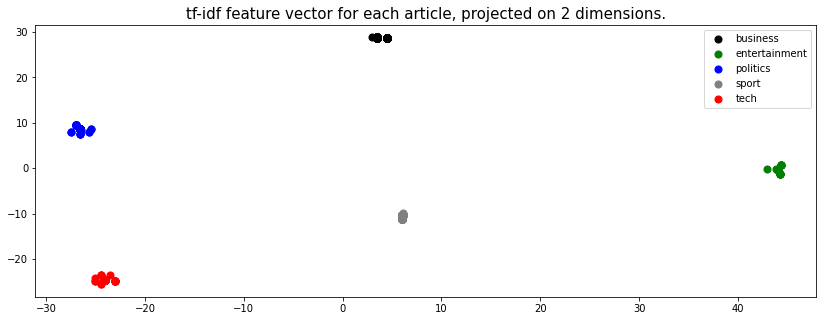

In [22]:
colors = ['black', 'green', 'blue', 'grey', 'red']

plt.figure(figsize=(14,5))

# Find points belonging to each category and plot them
for category, category_id in sorted(pdCategory_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=50, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()
plt.show()

# Data Preprocessing

In [23]:
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def preprocessDataset(train_text):
       
    #word tokenization using text-to-word-sequence
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
        
    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
        
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
        
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
       
        
    #--Stemming--
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
        
        
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
        
    return lem_text

# Word cloud

In [24]:
%time pdInputData['LemmatizedNewsText'] = pdInputData['NewsText'].apply(preprocessDataset)
text = pdInputData['NewsText']
category = pdInputData['NewsType']
text.head()

Wall time: 3min 12s


0    Ad sales boost Time Warner profit\n\nQuarterly...
1    Dollar gains on Greenspan speech\n\nThe dollar...
2    Yukos unit buyer faces loan claim\n\nThe owner...
3    High fuel prices hit BA's profits\n\nBritish A...
4    Pernod takeover talk lifts Domecq\n\nShares in...
Name: NewsText, dtype: object

In [25]:
# Install the following package
!pip install wordcloud --quiet

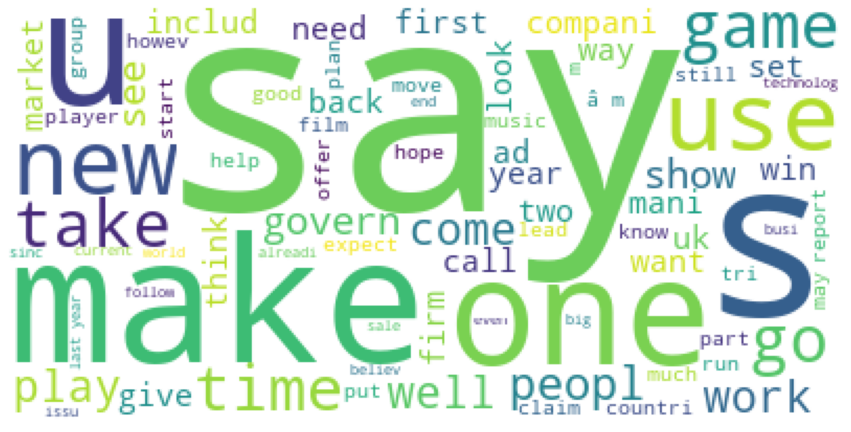

In [26]:
# word cloud of top 80 words from the corpus
# words like bitcoin, cryptocurrency, crypto, stock are visibly more prevelant
from wordcloud import WordCloud

cloud = WordCloud(background_color = "white", max_words = 80)
word_cloud = cloud.generate(pdInputData['LemmatizedNewsText'].str.cat(sep = '\n'))
plt.figure(figsize = (15,15))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [27]:
# if not installed install spacy
#!pip install spacy

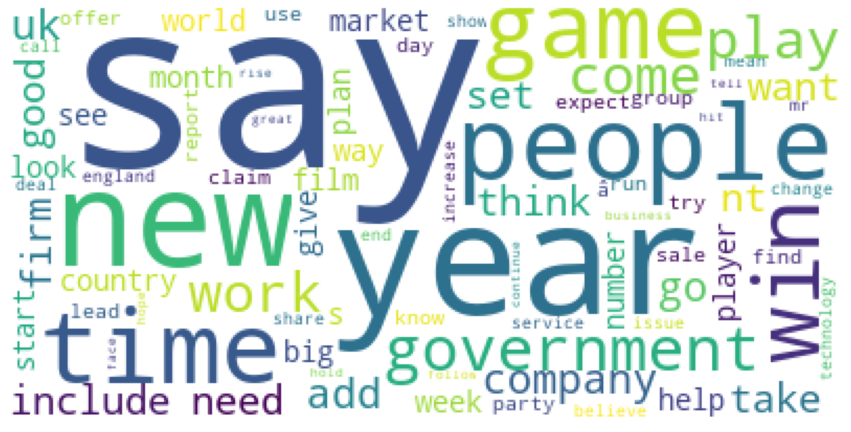

In [28]:
import re, spacy, string 
#import TextBlob

# lowercase each word
pdInputData['LNewsText'] = pdInputData['NewsText'].apply(lambda x: x.lower())

# remove digits
pdInputData['LNewsText'] = pdInputData['LNewsText'].apply(lambda x: re.sub('\w*\d\w*','', x))

# remove punctuations
pdInputData['LNewsText'] = pdInputData['LNewsText'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# lemmatization
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])
pdInputData['LNewsText'] = pdInputData['LNewsText'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
#pdInputData['LNewsText'] = pdInputData['LNewsText'].apply(lambda x: TextBlob(x).sentiment.polarity)



# word cloud of top 80 words from the corpus
# words like bitcoin, cryptocurrency, crypto, stock are visibly more prevelant

cloud = WordCloud(background_color = "white", max_words = 80)
word_cloud = cloud.generate(pdInputData['LNewsText'].str.cat(sep = '\n'))
plt.figure(figsize = (15,15))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [29]:
pdInputData.head()

,NewsText,NewsType,NewsTypeId,LemmatizedNewsText,LNewsText
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,0,ad sale boost time warner profit quarterli pro...,ad sale boost time warner profit \n\n quarterl...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,0,dollar gain greenspan speech dollar hit high l...,dollar gain greenspan speech \n\n dollar hit h...
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,0,yuko unit buyer face loan claim owner embattl ...,yukos unit buyer face loan claim \n\n owner em...
3,High fuel prices hit BA's profits\n\nBritish A...,business,0,high fuel price hit ba 's profit british airwa...,high fuel price hit bas profit \n\n british ai...
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,0,pernod takeov talk lift domecq share uk drink ...,pernod takeover talk lift domecq \n\n share uk...


# Model Testing

In [30]:
X = pdInputData.loc[:, 'LemmatizedNewsText'] #news_df.loc[:,'clean_text']
y = pdInputData.loc[:, 'NewsTypeId']  #news_df.loc[:,'category_id']

In [31]:
from sklearn.model_selection import train_test_split
# Basic validation: splitting the data 80-20-20 train/test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, pdInputData.index, test_size=0.2, random_state=55)
#X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=.25, random_state=10)

## Part 4: Model Training and Evaluation

In [32]:
#create list of model and accuracy dicts
perform_list = []

In [33]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

## Linear Support Vector Classification.

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

In [34]:
# Update this - keep SVM only 
# Create classwise - precision-recall
# NB 

In [35]:
from sklearn import metrics
def metric_report(yTest, yPred):
    print(f'accuracy: {accuracy_score(yTest, yPred)}')
    print('')
    print("Classification report: \n\n", metrics.classification_report(yTest, yPred))
    print('')
    confusion_matrix = metrics.confusion_matrix(yTest, yPred)
    print("Confusion matrix: \n\n", confusion_matrix)

In [36]:
from sklearn.pipeline import Pipeline

# nb = Pipeline([#('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
#               ])

model=Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', LinearSVC()),
              ])
model.fit(X_train,y_train)

test_predict = model.predict(X_test)

In [37]:
# model_name == 'Multinomial Naive Bayes':
metric_report(y_test, test_predict)

accuracy: 0.9812206572769953

Classification report: 

               precision    recall  f1-score   support

           0       1.00      0.98      0.99        97
           1       0.97      0.99      0.98        73
           2       0.99      0.97      0.98        78
           3       0.97      1.00      0.99       105
           4       0.97      0.96      0.97        73

    accuracy                           0.98       426
   macro avg       0.98      0.98      0.98       426
weighted avg       0.98      0.98      0.98       426


Confusion matrix: 

 [[ 95   0   0   1   1]
 [  0  72   1   0   0]
 [  0   0  76   1   1]
 [  0   0   0 105   0]
 [  0   2   0   1  70]]


In [38]:
### Printing out missclassied samples
def get_dict_value(index_value):
    return list(le_name_mapping.keys())[list(le_name_mapping.values()).index(index_value)]
def print_missclassified_samples(X_test, test_predict, y_test):
    for row_index, (input, prediction, label) in enumerate(zip (X_test, test_predict, y_test)):
        if label == 4:
            if prediction != label:
                print('Row', row_index, 'has been classified as', get_dict_value(prediction), 'and should be ', get_dict_value(label))

In [39]:
le_name_mapping=pdCategory_to_id
le_name_mapping

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [40]:
print_missclassified_samples(X_test, test_predict, y_test)

Row 119 has been classified as entertainment and should be  tech
Row 163 has been classified as sport and should be  tech
Row 393 has been classified as entertainment and should be  tech


In [41]:
### Implementing NB

In [42]:
from sklearn.pipeline import Pipeline

# nb = Pipeline([#('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
#               ])

nb=Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train,y_train)

test_predict = nb.predict(X_test)

# model_name == 'SVM':
metric_report(y_test, test_predict)

accuracy: 0.9553990610328639

Classification report: 

               precision    recall  f1-score   support

           0       0.94      0.99      0.96        97
           1       0.98      0.89      0.94        73
           2       0.94      0.97      0.96        78
           3       0.95      1.00      0.97       105
           4       0.98      0.89      0.94        73

    accuracy                           0.96       426
   macro avg       0.96      0.95      0.95       426
weighted avg       0.96      0.96      0.95       426


Confusion matrix: 

 [[ 96   0   0   0   1]
 [  3  65   4   1   0]
 [  1   0  76   1   0]
 [  0   0   0 105   0]
 [  2   1   1   4  65]]


In [43]:
print_missclassified_samples(X_test, test_predict, y_test)

Row 24 has been classified as business and should be  tech
Row 112 has been classified as sport and should be  tech
Row 138 has been classified as politics and should be  tech
Row 163 has been classified as sport and should be  tech
Row 206 has been classified as entertainment and should be  tech
Row 218 has been classified as sport and should be  tech
Row 316 has been classified as sport and should be  tech
Row 359 has been classified as business and should be  tech


# Model Selection

Refer to this link: https://machinelearningmastery.com/training-validation-test-split-and-cross-validation-done-right/